# Car Price Prediction - Practice Version

This notebook is a personal practice version of a car price prediction project.  
The goal is to explore, preprocess, and model car price data using Python and machine learning techniques.  

**Author:** Tatiana Leon

### Walkthrough
- Tune hyperparameters and estimate performance via cross-validation.
- Import libraries required for data handling, preprocessing, modeling, or plotting.
- Evaluate model performance (RMSE/MAE/R²).
- Define a regression model to predict car prices.
- Scale/normalize numeric features to stabilize training (esp. for linear/SVM models).
- Split data into train/test sets to estimate generalization and prevent leakage.

**Why it matters**
- A proper split prevents **data leakage**—information from the test set influencing training.
- Cross-validation gives a better estimate of out-of-sample error than a single split.
- Scaling helps gradient-based or distance-based models converge and perform better.
- Tracking multiple metrics (e.g., RMSE & MAE) gives a wider view of error behavior.

**Tips & pitfalls**
- Do preprocessing **inside** the Pipeline (or ColumnTransformer) to avoid leakage.
- Use Ridge/Lasso to handle multicollinearity and improve generalization.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

Load the raw dataset into a pandas DataFrame for processing.x

In [2]:
df = pd.read_csv('data.csv')
len(df)

11914

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
print(df.dtypes)

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object


### Data cleaning
Engineer/transform features (e.g., casting types, extracting date parts, text cleaning).

In [5]:
#Let's do a little bit of cleaning in the columns so it is easier to read them
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col ] = df[col].str.lower().str.replace(' ', '_')

In [6]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


### Exploratory data analysis
- Run quick EDA to inspect schema, types, and basic statistics.
- Create plots for EDA or diagnostics (e.g., residuals, feature effects).

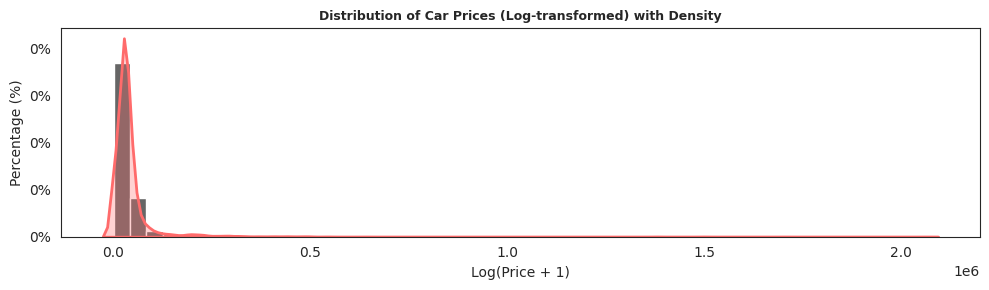

In [7]:
plt.figure(figsize=(10,3))
sns.set_style("white")

sns.histplot(df.msrp, bins=50, color='black', alpha=0.6, stat='density', edgecolor='white')
sns.kdeplot(df.msrp, color='#FF6B6B', linewidth=2, fill=True, alpha=0.3) #overlay density curve
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Car Prices (Log-transformed) with Density', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

We can see a concentration between prices 0 and 100,000, so let's make a zoom in over there.

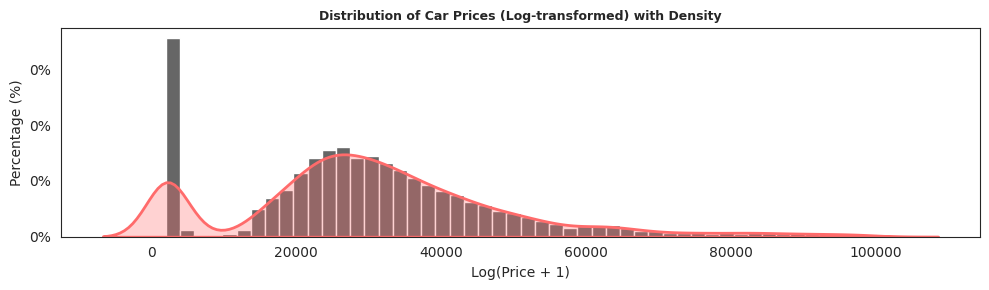

In [8]:
plt.figure(figsize=(10,3))
sns.set_style("white")

sns.histplot(df.msrp[df.msrp < 100000], bins=50, color='black', alpha=0.6, stat='density', edgecolor='white')
sns.kdeplot(df.msrp[df.msrp < 100000], color='#FF6B6B', linewidth=2, fill=True, alpha=0.3) #overlay density curve
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Car Prices (Log-transformed) with Density', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

We will get ride of the tail so the algorithm can respond better. We must add +1 to every value so we don't get an error as the log(0) is not possible.

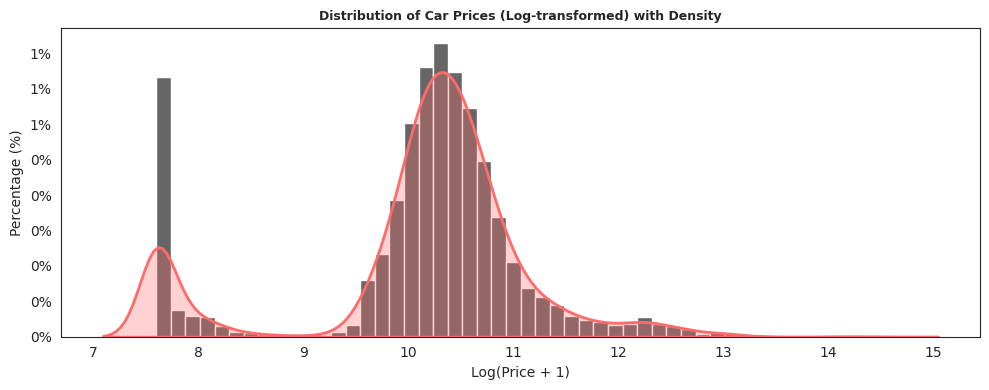

In [9]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(10,4))
sns.set_style("white")

sns.histplot(log_price, bins=50, color='black', alpha=0.6, stat='density', edgecolor='white')
sns.kdeplot(log_price, color='#FF6B6B', linewidth=2, fill=True, alpha=0.3) #overlay density curve
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Car Prices (Log-transformed) with Density', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

In [10]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Validation framework

- Apply or invert log transformations to stabilize variance and interpret errors.
- Create plots for EDA or diagnostics (e.g., residuals, feature effects).

**Why it matters**
- Log-transforming skewed targets (like price) can improve fit; remember to back-transform predictions.

In [11]:
np.random.seed(2)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test) 

In [12]:
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

y_train = np.log1p(y_train_orig)
y_val = np.log1p(y_val_orig)        
y_test = np.log1p(y_test_orig)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

### Linear Regression

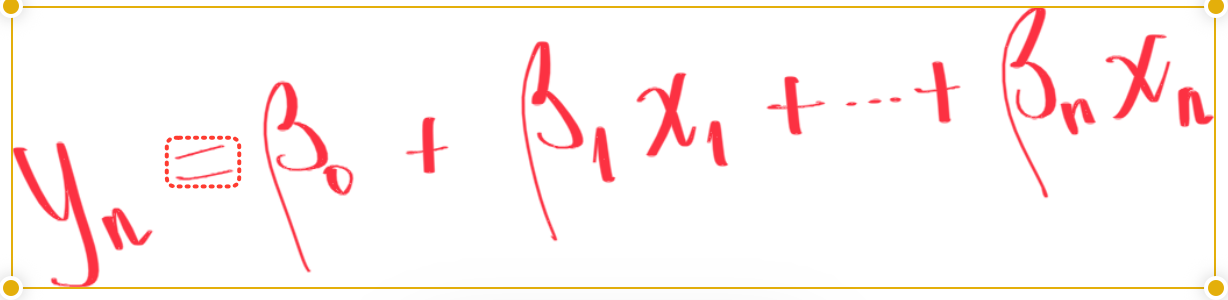

In [13]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

In [14]:
df.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

In [15]:
linear_base = ['engine_hp','engine_cylinders', 'city_mpg', 'highway_mpg', 'popularity' ]

In [16]:
df_train[linear_base]

,engine_hp,engine_cylinders,city_mpg,highway_mpg,popularity
2735,148.0,4.0,24,33,1385
6720,132.0,4.0,25,32,2031
5878,148.0,4.0,28,37,640
11190,90.0,4.0,16,18,873
4554,385.0,8.0,15,21,5657
...,...,...,...,...,...
434,300.0,6.0,20,31,3916
1902,210.0,4.0,24,30,873
9334,285.0,6.0,17,22,549
5284,563.0,12.0,13,21,86


Inspect and handle missing values (imputation or row/column drops).

In [17]:
X_train = df_train[linear_base].fillna(0)
X_val = df_val[linear_base].fillna(0)
X_test = df_test[linear_base].fillna(0)

X_train.isnull().sum()

engine_hp           0
engine_cylinders    0
city_mpg            0
highway_mpg         0
popularity          0
dtype: int64

In [18]:
X_train

,engine_hp,engine_cylinders,city_mpg,highway_mpg,popularity
2735,148.0,4.0,24,33,1385
6720,132.0,4.0,25,32,2031
5878,148.0,4.0,28,37,640
11190,90.0,4.0,16,18,873
4554,385.0,8.0,15,21,5657
...,...,...,...,...,...
434,300.0,6.0,20,31,3916
1902,210.0,4.0,24,30,873
9334,285.0,6.0,17,22,549
5284,563.0,12.0,13,21,86


- Fit/train the model on the training data.
- Define a regression model to predict car prices.
- Generate predictions on validation/test data or new samples.

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

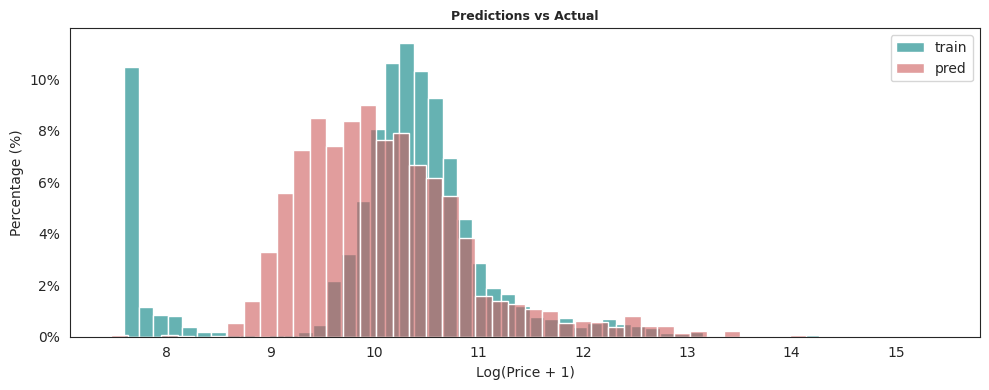

In [20]:
plt.figure(figsize=(10,4))
sns.set_style("white")

sns.histplot(y_train, bins=50, color='teal', label = 'train', alpha=0.6, stat='percent', edgecolor='white')
sns.histplot(y_pred, bins=50, color='indianred', label = 'pred', alpha=0.6, stat='percent', edgecolor='white')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.legend()

plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Predictions vs Actual', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

- Evaluate model performance (RMSE/MAE/R²).

**Why it matters**
- Tracking multiple metrics (e.g., RMSE & MAE) gives a wider view of error behavior.

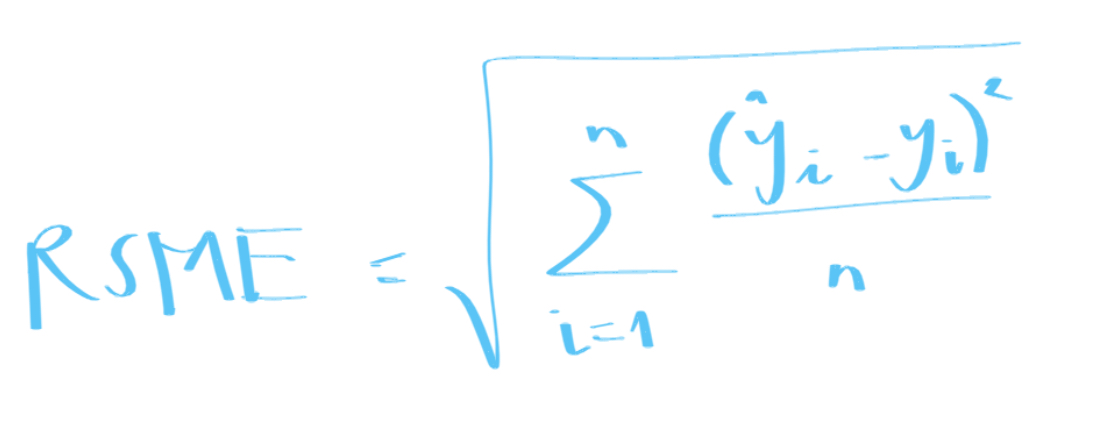

In [21]:
def rmse (y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [22]:
rmse(y_train, y_pred)

np.float64(0.7554192603920132)

In [23]:
y_pred = model.predict(X_val)

In [24]:
rmse(y_pred, y_val)

np.float64(0.7616530991301573)

### Feauture Engineering

In [25]:
df_train['age'] = 2017 - df_train.year
df_val['age'] = 2017 - df_val.year
df_test['age'] = 2017 - df_test.year

In [26]:
features = linear_base + ['age']

In [27]:
X_train = df_train[features].fillna(0)
X_val = df_val[features].fillna(0)
X_test = df_test[features].fillna(0)

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
rmse(y_train, y_pred)

np.float64(0.5175055465840046)

In [29]:
np.unique(df_train.number_of_doors)

array([ 2.,  3.,  4., nan])

In [30]:
df_train['number_doors_2'] = (df_train.number_of_doors == 2).astype('int')
df_train['number_doors_3'] = (df_train.number_of_doors == 3).astype('int')
df_train['number_doors_4'] = (df_train.number_of_doors == 4).astype('int')

df_val['number_doors_2'] = (df_val.number_of_doors == 2).astype('int')
df_val['number_doors_3'] = (df_val.number_of_doors == 3).astype('int')
df_val['number_doors_4'] = (df_val.number_of_doors == 4).astype('int')

df_test['number_doors_2'] = (df_test.number_of_doors == 2).astype('int')
df_test['number_doors_3'] = (df_test.number_of_doors == 3).astype('int')
df_test['number_doors_4'] = (df_test.number_of_doors == 4).astype('int')

features = features + ['number_doors_2'] + ['number_doors_3'] + ['number_doors_4']

X_train = df_train[features].fillna(0)
X_val = df_val[features].fillna(0)
X_test = df_test[features].fillna(0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
rmse(y_train, y_pred)

np.float64(0.5150615580371418)

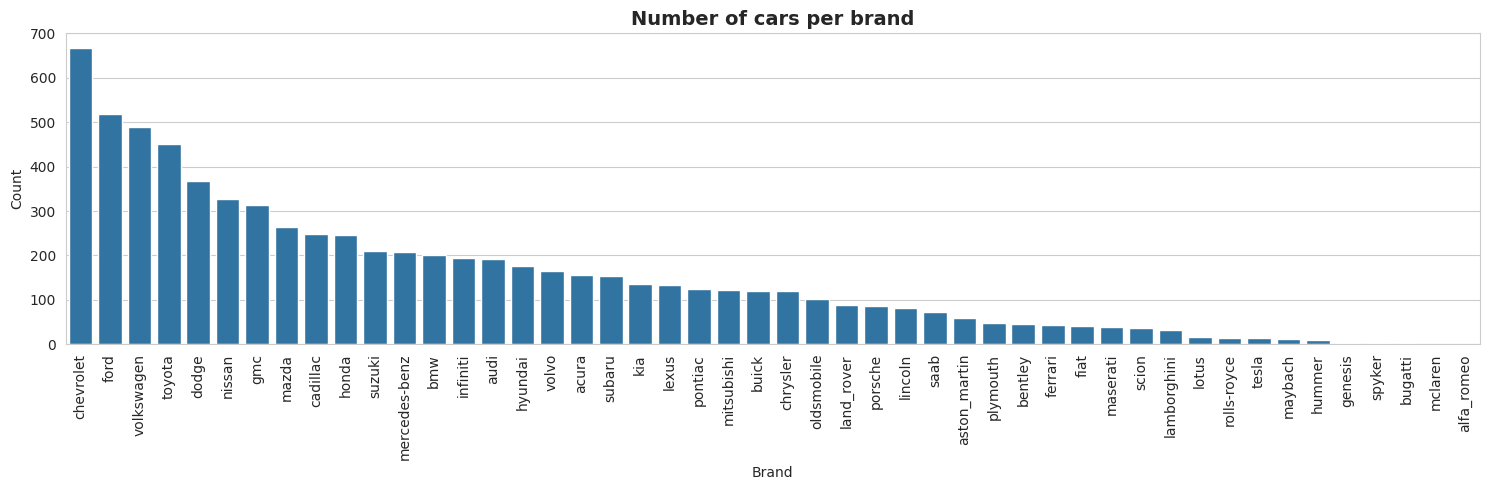

In [31]:
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")

sns.countplot(x='make', data=df_train, order = df_train['make'].value_counts().index)

plt.title('Number of cars per brand', fontsize=14, weight='bold')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=90)  # rotar etiquetas si son largas
plt.tight_layout()
plt.show()

In [32]:
categories = ['make', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'market_category', 
              'vehicle_size','vehicle_style']

In [33]:
def dummy_categories(df):
    #make
    for i in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'make_%s' % i
        df[feature] = (df.make == i).astype('int')
        features.append(feature)

    #engine_fuel_type
    for i in ['regular_unleaded', 'premium_unleaded_(required)', 'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'engineft_%s' % i
        df[feature] = (df.engine_fuel_type == i).astype('int')
        features.append(feature)

    #transmission_type
    for i in ['automatic', 'manual', 'automated_manual']:
        feature = 'transmitype_%s' % i
        df[feature] = (df.transmission_type == i).astype('int')
        features.append(feature)

    #driven_wheels
    for i in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive','four_wheel_drive']:
        feature = 'drivenw_%s' % i
        df[feature] = (df.driven_wheels == i).astype('int')
        features.append(feature)
    
    #market_category
    for i in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'marketc_%s' % i
        df[feature] = (df.market_category == i).astype('int')
        features.append(feature)

    #vehicle_size
    for i in ['compact', 'midsize', 'large']:
        feature = 'vehiclesize_%s' % i
        df[feature] = (df.vehicle_size == i).astype('int')
        features.append(feature)

    #vehicle_style
    for i in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'vehiclestyle_%s' % i
        df[feature] = (df.vehicle_style == i).astype('int')
        features.append(feature)
    
    return df, features

In [34]:
df_train, features = dummy_categories(df_train)
df_val, features = dummy_categories(df_val)
df_test, features = dummy_categories(df_test)

X_train = df_train[features].fillna(0)
X_val = df_val[features].fillna(0)
X_test = df_test[features].fillna(0)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print('rmse_train:', rmse(y_train, y_pred))

y_pred = model.predict(X_val)
print('rmse_val:', rmse(y_val, y_pred))

rmse_train: 0.464312131145101
rmse_val: 0.4602253519135794


### Regularizaton
- Tune hyperparameters and estimate performance via cross-validation.
- Fit/train the model on the training data.
- Evaluate model performance (RMSE/MAE/R²).
- Define a regression model to predict car prices.
- Build a Pipeline to tie preprocessing and model together reproducibly.
- Scale/normalize numeric features to stabilize training (esp. for linear/SVM models).

**Why it matters**
- Pipelines make training & inference consistent and reduce mistakes when deploying.
- Cross-validation gives a better estimate of out-of-sample error than a single split.
- Scaling helps gradient-based or distance-based models converge and perform better.
- Tracking multiple metrics (e.g., RMSE & MAE) gives a wider view of error behavior.

**Tips & pitfalls**
- Do preprocessing **inside** the Pipeline (or ColumnTransformer) to avoid leakage.
- Use Ridge/Lasso to handle multicollinearity and improve generalization

In [35]:
#Pipelines
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(max_iter = 10000))
])

#Hyperparameters
ridge_params = {'model__alpha': np.logspace(-3,3,13)}
lasso_params = {'model__alpha': np.logspace(-3,1,9)}


#GridSearch CrossValidation
ridge_cv = GridSearchCV(ridge_pipe, ridge_params, cv=5, scoring= 'neg_root_mean_squared_error', n_jobs = -1)
lasso_cv = GridSearchCV(lasso_pipe, lasso_params, cv=5, scoring= 'neg_root_mean_squared_error', n_jobs = -1)

#Fit models
ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01])},
             scoring='neg_root_mean_squared_error')

In [36]:
y_pred = ridge_cv.predict(X_train)
print('ridge_rmse_train:', rmse(y_train, y_pred))

y_pred = ridge_cv.predict(X_val)
print('ridge_rmse_val:', rmse(y_val, y_pred))

ridge_rmse_train: 0.46759474534241297
ridge_rmse_val: 0.4631265509090883


In [37]:
y_pred = lasso_cv.predict(X_train)
print('lasso_rmse_train:', rmse(y_train, y_pred))
print('real_lasso_rmse_train:', np.expm1(rmse(y_train, y_pred)) - 1)

y_pred = ridge_cv.predict(X_val)
print('ridge_rmse_val:', rmse(y_val, y_pred))
print('real_ridge_rmse_train:', np.expm1(rmse(y_val, y_pred)) - 1)

lasso_rmse_train: 0.46653212111900544
real_lasso_rmse_train: -0.40554478305453323
ridge_rmse_val: 0.4631265509090883
real_ridge_rmse_train: -0.4109655765568224


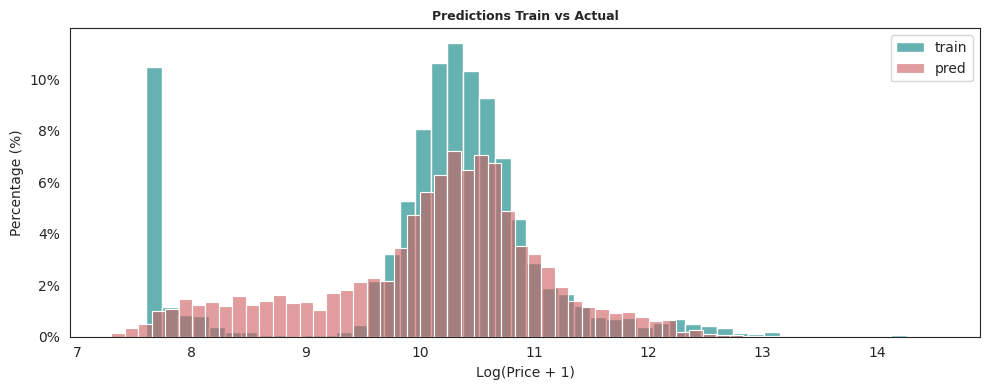

In [38]:
y_pred = lasso_cv.predict(X_train)

plt.figure(figsize=(10,4))
sns.set_style("white")

sns.histplot(y_train, bins=50, color='teal', label = 'train', alpha=0.6, stat='percent', edgecolor='white')
sns.histplot(y_pred, bins=50, color='indianred', label = 'pred', alpha=0.6, stat='percent', edgecolor='white')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.legend()

plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Predictions Train vs Actual', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

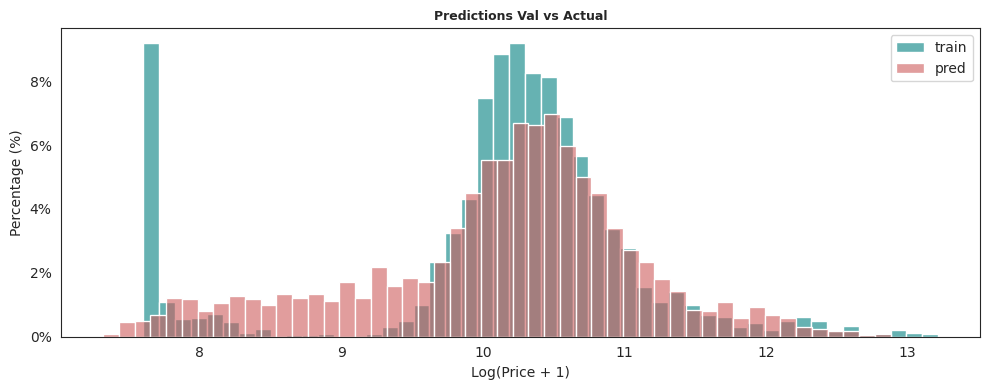

In [39]:
y_pred = lasso_cv.predict(X_val)

plt.figure(figsize=(10,4))
sns.set_style("white")

sns.histplot(y_val, bins=50, color='teal', label = 'train', alpha=0.6, stat='percent', edgecolor='white')
sns.histplot(y_pred, bins=50, color='indianred', label = 'pred', alpha=0.6, stat='percent', edgecolor='white')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.legend()

plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Predictions Val vs Actual', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

Use Ridge/Lasso to handle multicollinearity and improve generalization.

In [40]:
df_full_train = pd.concat([X_train, X_val])
X_full_train = df_full_train.reset_index(drop=True)

y_full_train = np.concatenate([y_train, y_val])

In [41]:
#Fit models
lasso_cv.fit(X_full_train, y_full_train)


y_pred = lasso_cv.predict(X_test)
print('ridge_rmse_train:', rmse(y_test, y_pred))

ridge_rmse_train: 0.4594798260113138


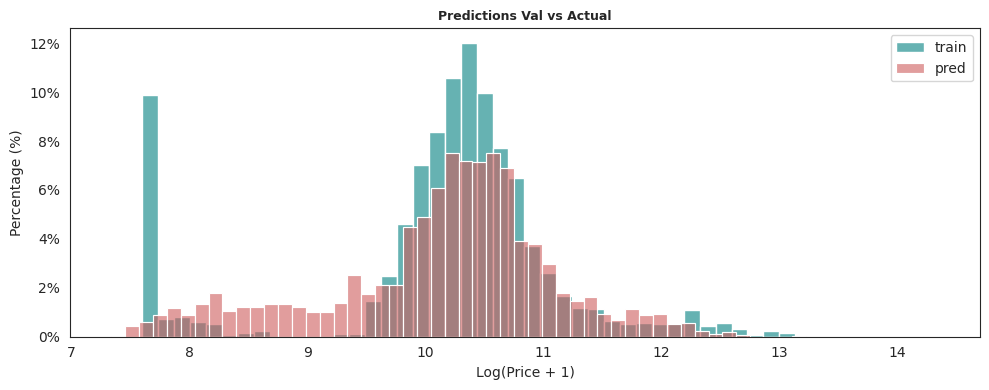

In [42]:
y_pred = lasso_cv.predict(X_test)

plt.figure(figsize=(10,4))
sns.set_style("white")

sns.histplot(y_test, bins=50, color='teal', label = 'train', alpha=0.6, stat='percent', edgecolor='white')
sns.histplot(y_pred, bins=50, color='indianred', label = 'pred', alpha=0.6, stat='percent', edgecolor='white')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.legend()

plt.xlabel('Log(Price + 1)')
plt.ylabel('Percentage (%)')
plt.title('Predictions Val vs Actual', fontsize=9, weight='bold')

plt.tight_layout()
plt.show()